In [1]:
# require("CASdatasets") - Not necessary, as we saved the data as parquet file
if (!require("rpart")) install.packages("rpart")
if (!require("rpart.plot")) install.packages("rpart.plot")
if (!require("arrow")) install.packages("arrow")
if (!require("caret")) install.packages("caret", dependencies=TRUE)
if (!require("ggplot2")) install.packages("ggplot2")
if (!require("rattle")) install.packages("rattle")


require("rpart")
require("rpart.plot")
require("arrow")
require("caret")
require("ggplot2")
require("rattle")



options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 150);

start_time <- Sys.time()

Le chargement a nécessité le package : rpart

Le chargement a nécessité le package : rpart.plot

Le chargement a nécessité le package : arrow


Attachement du package : 'arrow'


L'objet suivant est masqué depuis 'package:utils':

    timestamp


Le chargement a nécessité le package : caret

Le chargement a nécessité le package : ggplot2

Le chargement a nécessité le package : lattice

Le chargement a nécessité le package : rattle

Le chargement a nécessité le package : tibble

Le chargement a nécessité le package : bitops

Rattle: A free graphical interface for data science with R.
Version 5.5.1 Copyright (c) 2006-2021 Togaware Pty Ltd.
Entrez 'rattle()' pour secouer, faire vibrer, et faire défiler vos données.



# Random Forest on Count Data

Let us first install the random forest package for count data, called **rfCountData**. Note that Rtools is required on Windows.

In [2]:
# If 401 error, uncomment the following line:
Sys.unsetenv("GITHUB_PAT")
if (!require(devtools)) install.packages("devtools")
devtools::install_github("fpechon/rfCountData")


# require("CASdatasets")
require("rfCountData")
require("caret")
require("tidyr")
require("arrow")

Le chargement a nécessité le package : devtools

Le chargement a nécessité le package : usethis

Skipping install of 'rfCountData' from a github remote, the SHA1 (d9334631) has not changed since last install.
  Use `force = TRUE` to force installation

Le chargement a nécessité le package : rfCountData

rfCountData 0.3.0


Attachement du package : 'rfCountData'


L'objet suivant est masqué depuis 'package:rattle':

    importance


Le chargement a nécessité le package : tidyr



Let us load the data from the previously saved parquet file.

In [3]:
dataset = read_parquet(file = "../data/dataset.parquet")

Similarly as in the previous session, we will split into a training and testing set. We are using the same seed to obtain identical training/testing sets across the various sessions.

In [4]:
set.seed(21)
in_training = createDataPartition(dataset$ClaimNb, times = 1, p = 0.8, list = FALSE)
training_set = dataset[in_training, ]
testing_set = dataset[-in_training, ]

The package **randomForest** allows to perform regression and classification. However, the split criterion in the regression case is based on the MSE, which may not be relevant for count data. Moreover, it did not allow the inclusion of an offset to take into account the different exposures of the policyholders.

The package **rfCountData** tries to correct these issues. It is to be used only on count data.

The use of the package is similar to the randomForest. Here, the main function is called rfPoisson.

In [5]:
set.seed(5) # For reproducibility
m0_rf = rfPoisson(x = training_set[,c("DriverAge", "CarAge")],
                  offset = log(training_set$Exposure),
                  y = training_set$ClaimNb,
                  ntree = 50, # Number of trees in the forest
                  nodesize = 4000, # Minimum number of observations in each leaf
                  mtry=2, # Number of variables drawn at each node
                  importance=TRUE,
                  keep.inbag = TRUE,
                  do.trace=TRUE)

     | OOB (1 tree) | OOB (forest) |
Tree |Loss Function |Loss Function |
   1 |     0.254973 |     0.254973 |
   2 |     0.258401 |     0.255019 |
   3 |     0.251483 |     0.254255 |
   4 |     0.254614 |     0.254435 |
   5 |     0.254218 |     0.254314 |
   6 |     0.252501 |     0.254248 |
   7 |     0.256266 |     0.254309 |
   8 |     0.252822 |      0.25431 |
   9 |     0.256663 |     0.254329 |
  10 |     0.255303 |     0.254301 |
  11 |      0.25503 |     0.254225 |
  12 |     0.254794 |     0.254125 |
  13 |     0.255032 |     0.254155 |
  14 |      0.25252 |     0.254125 |
  15 |     0.257642 |     0.254151 |
  16 |     0.255552 |     0.254158 |
  17 |     0.254268 |     0.254183 |
  18 |     0.252687 |     0.254151 |
  19 |     0.255848 |     0.254156 |
  20 |     0.253972 |     0.254148 |
  21 |     0.254031 |     0.254133 |
  22 |     0.250106 |     0.254113 |
  23 |     0.256625 |     0.254104 |
  24 |     0.255553 |       0.2541 |
  25 |     0.256271 |     0.254098 |
 

In [6]:
?rfPoisson

## Hyperparameters

In a random forest, we can play around with the following parameters

- ntree: the number of trees of the forest
- mtry: the number of variables randomly sampled as candidates at each split
- nodesize : Number of cases in the terminal nodes (= leaves).
- maxnodes : Maximum number of terminal nodes trees in the forest can have

We also have some parameters related to the sampling done for each tree:

- replace: Are the sampling of cases with or without replacement
- sampsize: Size of the sampled cases

## A note on Out-of-bag (OOB)

In average, we expect more or less 36.788% observations to be OOB (why ?). We can check if we obtained similar number of OOB. Let us compute on tree number 1, how many times each observation has been drawn.

In [7]:
m0_rf$inbag[,1] %>% 
  table() %>% 
  prop.table %>% 
  round(3)

.
    0     1     2     3     4     5     6     7     8 
0.368 0.367 0.185 0.061 0.015 0.003 0.001 0.000 0.000 

Similarly on tree number 2:

In [8]:
m0_rf$inbag[,2] %>% 
  table() %>% 
  prop.table %>% 
  round(3)

.
    0     1     2     3     4     5     6     7     8 
0.367 0.370 0.183 0.061 0.015 0.003 0.001 0.000 0.000 

At which point has every observation been OOB in at least one bootstrap sample (one tree) ?

In [9]:
# Cumulative product (will be 0 once the policy has been OOB for the first time)
OOB_analysis = apply(m0_rf$inbag, 1, cumprod) 
# OOB_analysis is a 50 x n matrix. On each row, we take the sum. The first row
# with a sum = 0 means that all observations have been OOB at least once.
which.min(apply(OOB_analysis, 1, sum))

[1] 29

It can even be showed that for $ \lim_{ntree \rightarrow \infty} OOBE = \text{LLO-CV} $ the  converges to the LOO-CV error estimate (leave one out cross validation) which is unbiased but with higher variance with respect to k-fold CV with k<n. (see Hastie, T., Tibshirani, R., Friedman, J. (2001). The Elements of Statistical Learning.)

Therefore, one could use the Out-of-bag error to find the optimal hyperparameters of the random forest.

## Dependence plot

If we want some idea of the marginal effect of the variables, we can use the partial dependence plots

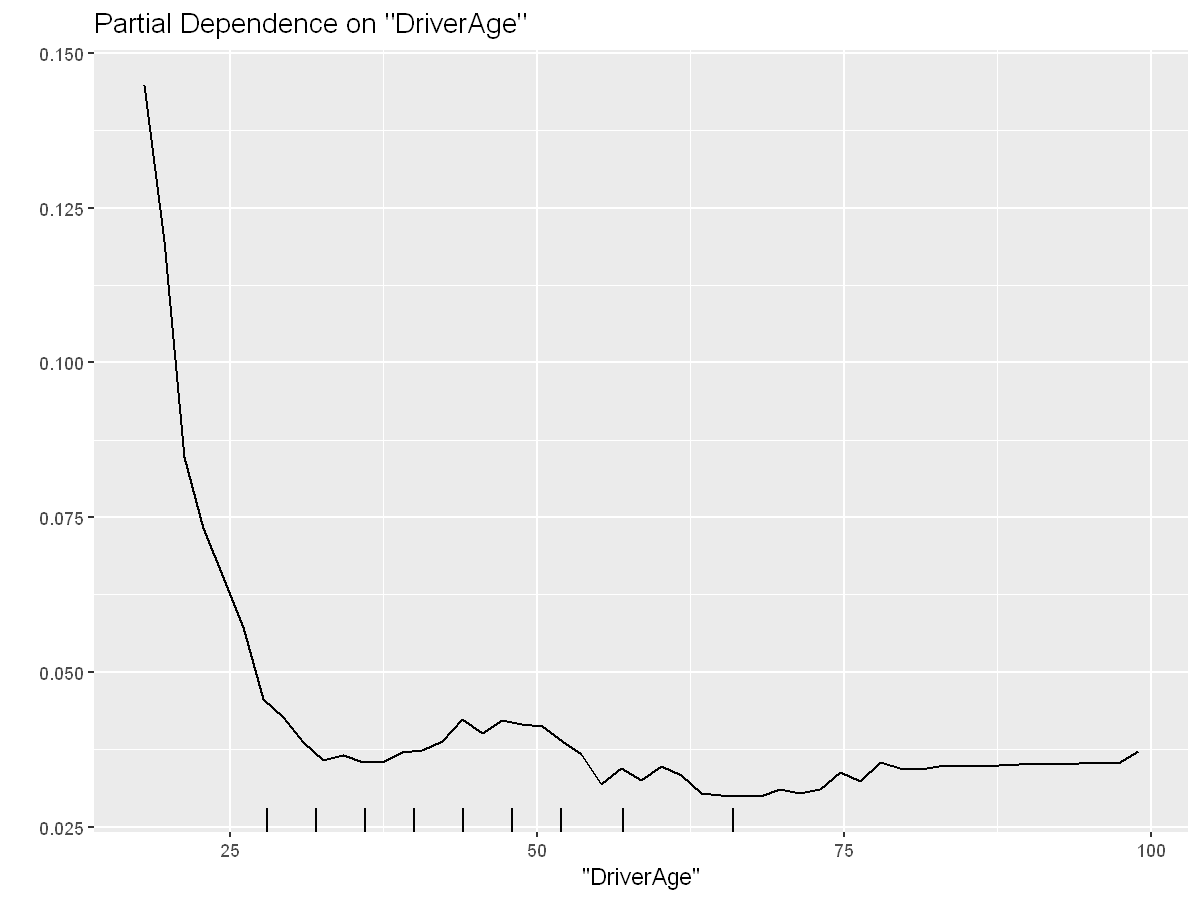

In [10]:
par(mfrow = c(1, 2))
partialPlot(m0_rf, training_set, offset = log(training_set$Exposure), x.var = "DriverAge")

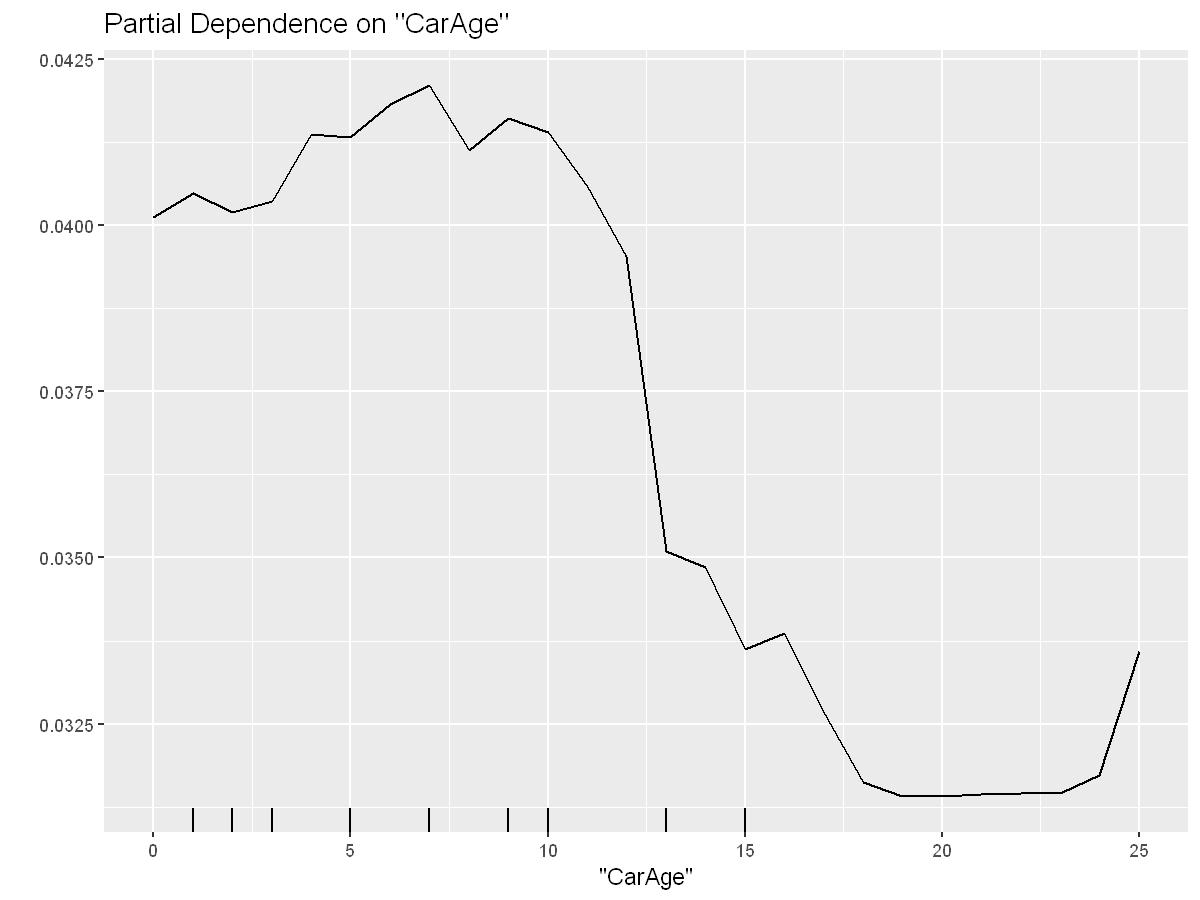

In [11]:
partialPlot(m0_rf, training_set, offset = log(training_set$Exposure), x.var = "CarAge")


## Variable Importance

We can extract the variable importance. The importance is computed using permutations. Basically, for each variable at a time, a shuffle is performed. The increase of the OOB error is then used as importance metric.

In [12]:
importance(m0_rf)

,%IncLossFunction
DriverAge,0.0048500723
CarAge,0.0007017537


## Deviance

We can see the deviance (on the training_set) as a function of the number of trees. After a few iterations, the error will stabilize.

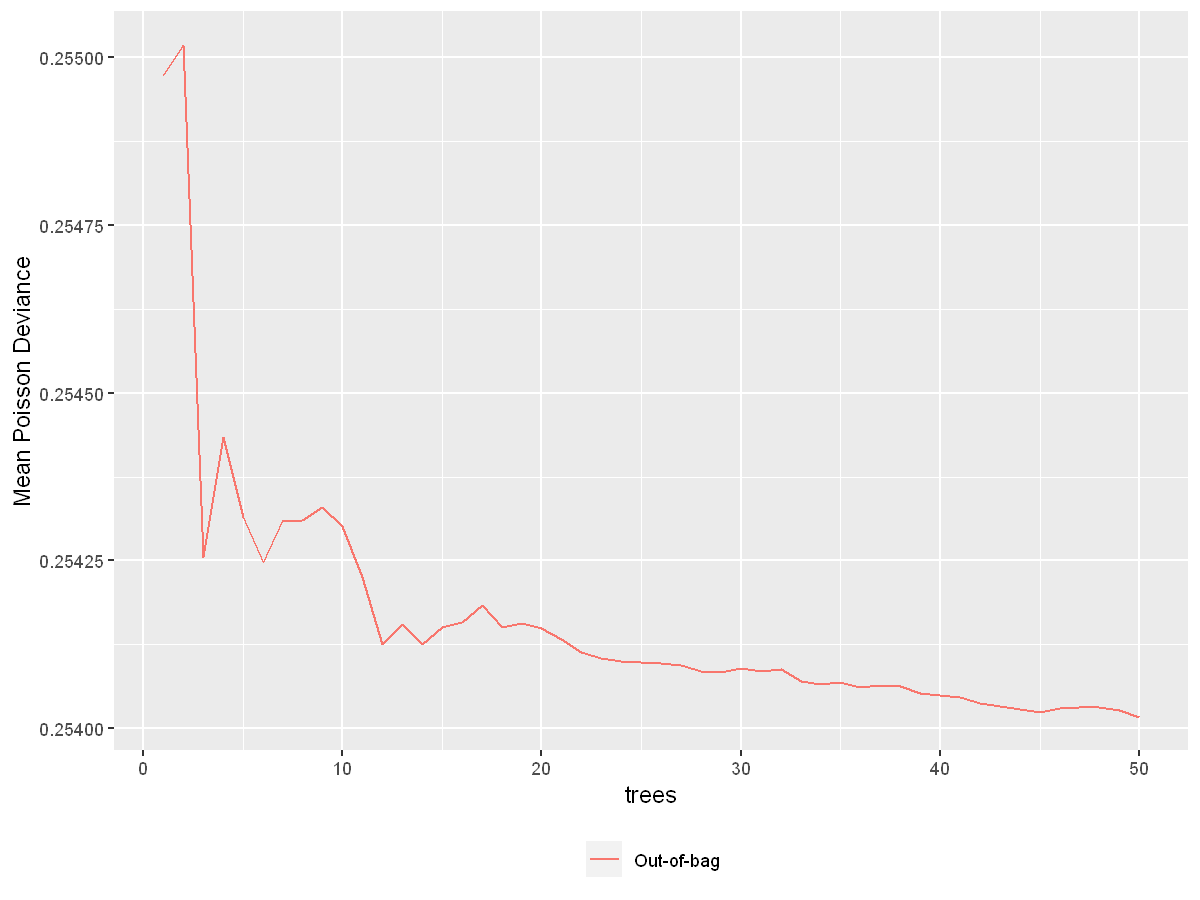

In [13]:
plot(m0_rf)

For the sake of comparison, let’s decrease the nodesize to 2500, and let mtry to 2 and increase the number of trees.



In [14]:
set.seed(5)
m1_rf = rfPoisson(x = training_set[, c("DriverAge", "CarAge")], offset = log(training_set$Exposure),
    y = training_set$ClaimNb, ntree = 100, nodesize = 2500, mtry = 2, importance = TRUE,
    do.trace = TRUE)

     | OOB (1 tree) | OOB (forest) |
Tree |Loss Function |Loss Function |
   1 |     0.255425 |     0.255425 |
   2 |     0.258837 |     0.255434 |
   3 |     0.251976 |     0.254612 |
   4 |     0.255408 |     0.254765 |
   5 |     0.254517 |     0.254574 |
   6 |     0.253401 |     0.254543 |
   7 |     0.257201 |     0.254582 |
   8 |     0.253392 |       0.2546 |
   9 |     0.256922 |     0.254564 |
  10 |     0.255514 |     0.254499 |
  11 |     0.255216 |     0.254406 |
  12 |     0.255001 |     0.254289 |
  13 |     0.255943 |     0.254361 |
  14 |     0.253414 |     0.254324 |
  15 |      0.25776 |     0.254338 |
  16 |     0.256643 |     0.254348 |
  17 |     0.254443 |     0.254327 |
  18 |      0.25273 |     0.254295 |
  19 |     0.256177 |     0.254302 |
  20 |     0.254574 |     0.254287 |
  21 |     0.254419 |     0.254258 |
  22 |     0.250441 |     0.254246 |
  23 |     0.256611 |     0.254242 |
  24 |      0.25671 |      0.25424 |
  25 |     0.257349 |     0.254238 |
 

We can again see the error (mean deviance) as a function of the number of trees

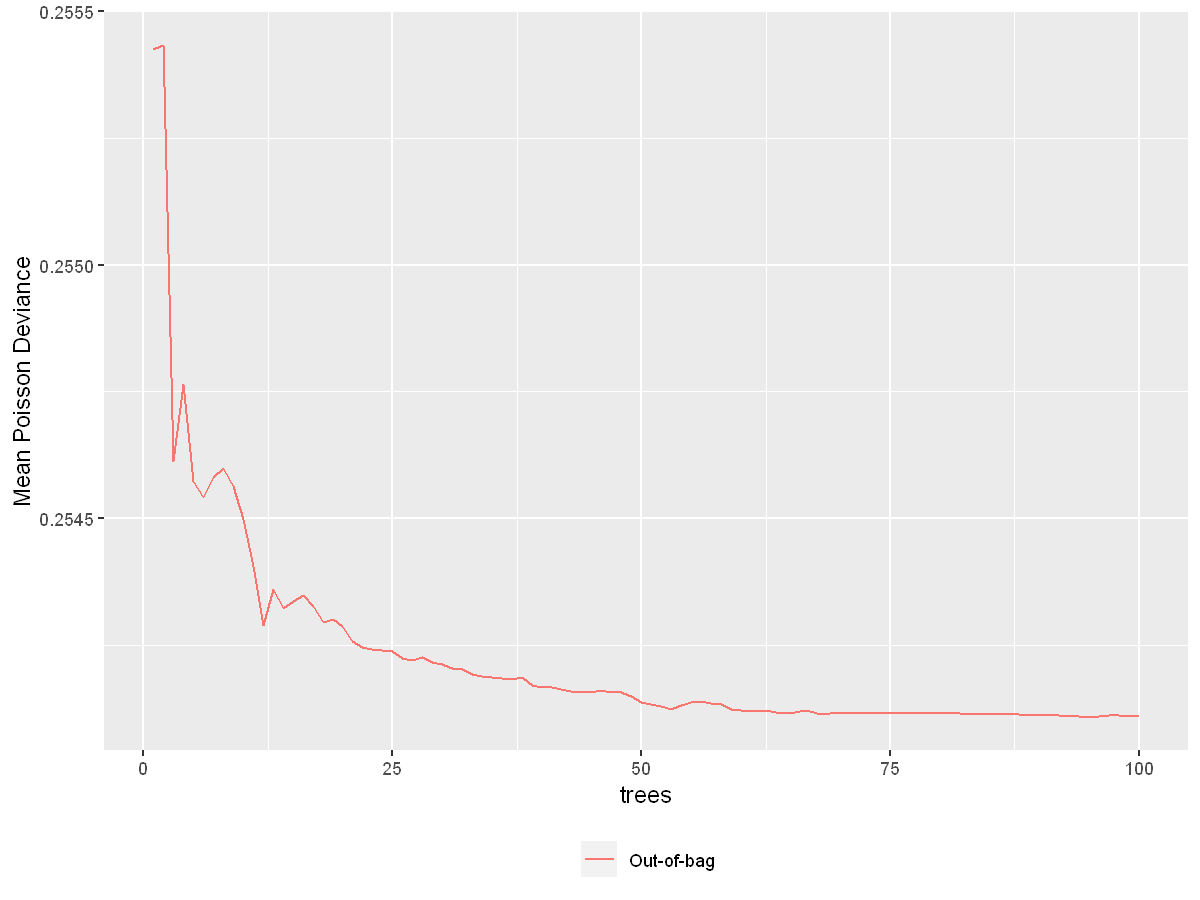

In [15]:
plot(m1_rf)

In [16]:
importance(m1_rf)

,%IncLossFunction
DriverAge,0.0048666932
CarAge,0.0008093661


Finally, we can compute the deviance on the testing set

In [17]:
2 * (sum(dpois(x = testing_set$ClaimNb, lambda = testing_set$ClaimNb, log = TRUE)) -
    sum(dpois(x = testing_set$ClaimNb, lambda = predict(m1_rf, testing_set[, c("DriverAge",
        "CarAge")], log(testing_set$Exposure)), log = TRUE)))

[1] 20611.33

At this point, we only used two variables, and the mtry parameter was set to 2. This means, that for each tree, and for each node, we drew 2 variables … out of 2: the random sampling of features did not really take place. When mtry = # variables, we are essentially constructing **bagged trees** …

Obviously, random forests are supposed to work with a greater amount of variables. By default, mtry will be **a third** of the total number of features.

If we had set mtry to 1, we would have constructed each node with one of the variables and this one would have been chosen randomly. The ‘split’ point would however been selected using the loss function.

We can give it go and try with mtry = 1.

In [18]:
set.seed(8)
m2_rf = rfPoisson(x = training_set[, c("DriverAge", "CarAge")], offset = log(training_set$Exposure),
    y = training_set$ClaimNb, ntree = 100, nodesize = 2500, mtry = 1, importance = TRUE,
    do.trace = TRUE)

     | OOB (1 tree) | OOB (forest) |
Tree |Loss Function |Loss Function |
   1 |     0.257456 |     0.257456 |
   2 |     0.252383 |     0.254238 |
   3 |     0.258713 |     0.254828 |
   4 |     0.255986 |     0.254727 |
   5 |     0.254311 |     0.254247 |
   6 |     0.257323 |     0.253937 |
   7 |     0.255851 |     0.254421 |
   8 |     0.251224 |       0.2544 |
   9 |     0.250433 |     0.254278 |
  10 |     0.256591 |     0.254355 |
  11 |     0.257084 |     0.254287 |
  12 |     0.253652 |     0.254239 |
  13 |     0.252985 |     0.254275 |
  14 |     0.253399 |     0.254292 |
  15 |     0.255514 |     0.254204 |
  16 |     0.253015 |     0.254122 |
  17 |     0.252445 |       0.2541 |
  18 |     0.256582 |     0.254091 |
  19 |     0.255866 |     0.254054 |
  20 |     0.253915 |     0.254047 |
  21 |     0.252414 |     0.254027 |
  22 |     0.255331 |     0.254028 |
  23 |     0.253187 |     0.254039 |
  24 |     0.258752 |     0.254036 |
  25 |     0.253572 |     0.254037 |
 

Let us take a look at the variable importance.

In [19]:
importance(m2_rf)

,%IncLossFunction
DriverAge,0.0046968329
CarAge,0.0007813552


In [20]:
2 * (sum(dpois(x = testing_set$ClaimNb, lambda = testing_set$ClaimNb, log = TRUE)) -
    sum(dpois(x = testing_set$ClaimNb, lambda = predict(m2_rf, testing_set[, c("DriverAge",
        "CarAge")], log(testing_set$Exposure)), log = TRUE)))

[1] 20597.86

# Use all the variables

Some variables are factors, others are numerical variables. We can directly construct our random forest. We will set **mtry = floor(7/3) = 2** (default value).



In [21]:
set.seed(5)
m4_rf = rfPoisson(x = training_set[, c("Power", "CarAge", "DriverAge", "Brand", "Gas",
    "Region", "Density")], offset = log(training_set$Exposure), y = training_set$ClaimNb,
    ntree = 100, nodesize = 2500, mtry = 2, importance = TRUE, do.trace = TRUE)

     | OOB (1 tree) | OOB (forest) |
Tree |Loss Function |Loss Function |
   1 |     0.253678 |     0.253678 |
   2 |     0.250882 |     0.252763 |
   3 |     0.253752 |      0.25314 |
   4 |     0.254749 |     0.253318 |
   5 |     0.252189 |     0.253149 |
   6 |     0.254484 |     0.252996 |
   7 |     0.254361 |     0.253028 |
   8 |     0.251722 |      0.25286 |
   9 |     0.254173 |     0.252857 |
  10 |     0.256132 |     0.252742 |
  11 |     0.254712 |      0.25267 |
  12 |       0.2563 |     0.252695 |
  13 |     0.252418 |     0.252583 |
  14 |     0.250281 |     0.252526 |
  15 |     0.252693 |     0.252554 |
  16 |     0.257495 |     0.252504 |
  17 |     0.255899 |     0.252496 |
  18 |     0.253853 |     0.252497 |
  19 |     0.257495 |     0.252488 |
  20 |     0.252996 |     0.252457 |
  21 |      0.25576 |     0.252431 |
  22 |     0.256235 |     0.252402 |
  23 |     0.256207 |     0.252381 |
  24 |     0.256501 |     0.252329 |
  25 |      0.25488 |     0.252312 |
 

When a variable is a factor (not ordered), at each node, the average claim frequency for each level will be computed. Then, the levels will be sorted based on these claim frequencies, and a splitting among these sorted levels will be identified. If a variable a an ordered factor, the splitting point will be done on the ‘natural’ ordering of the levels, similarly to how a numerical variable is split.

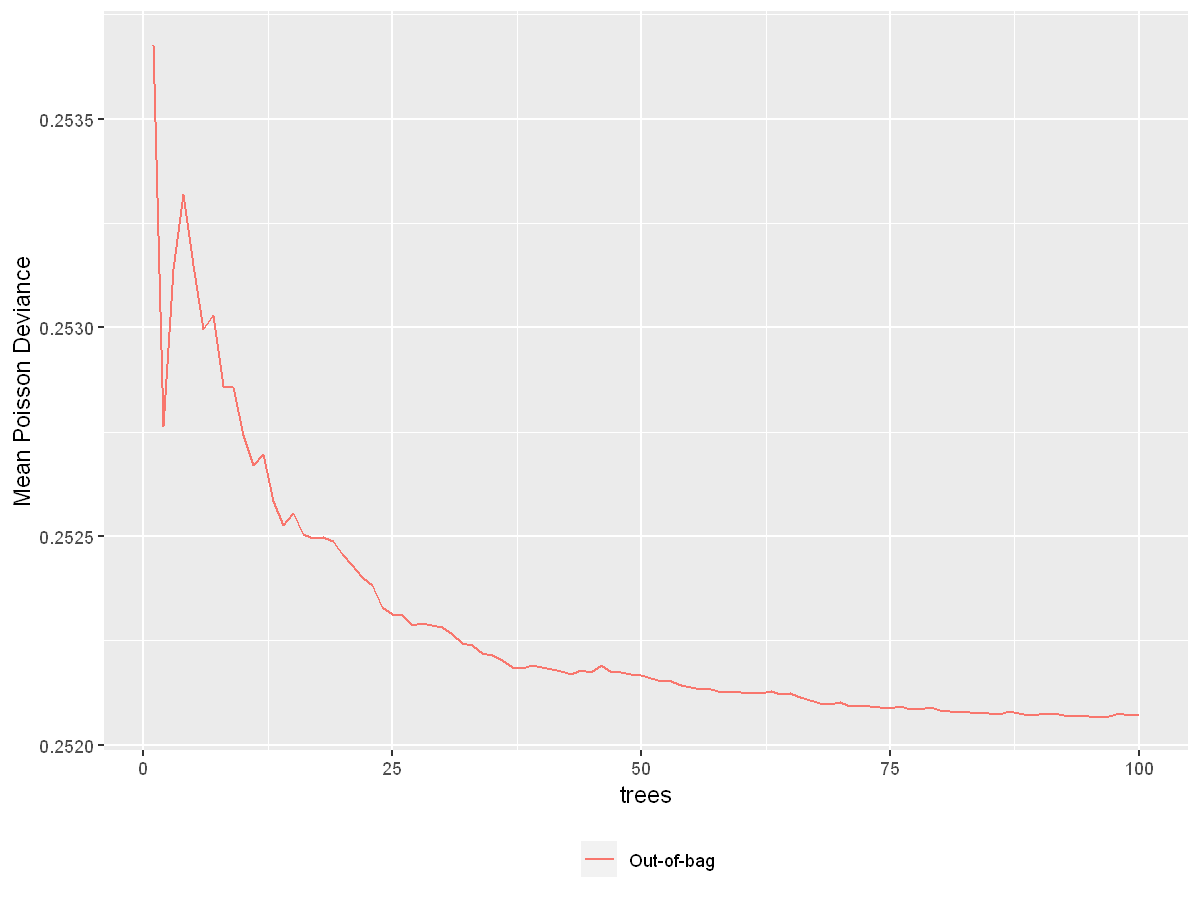

In [22]:
plot(m4_rf)

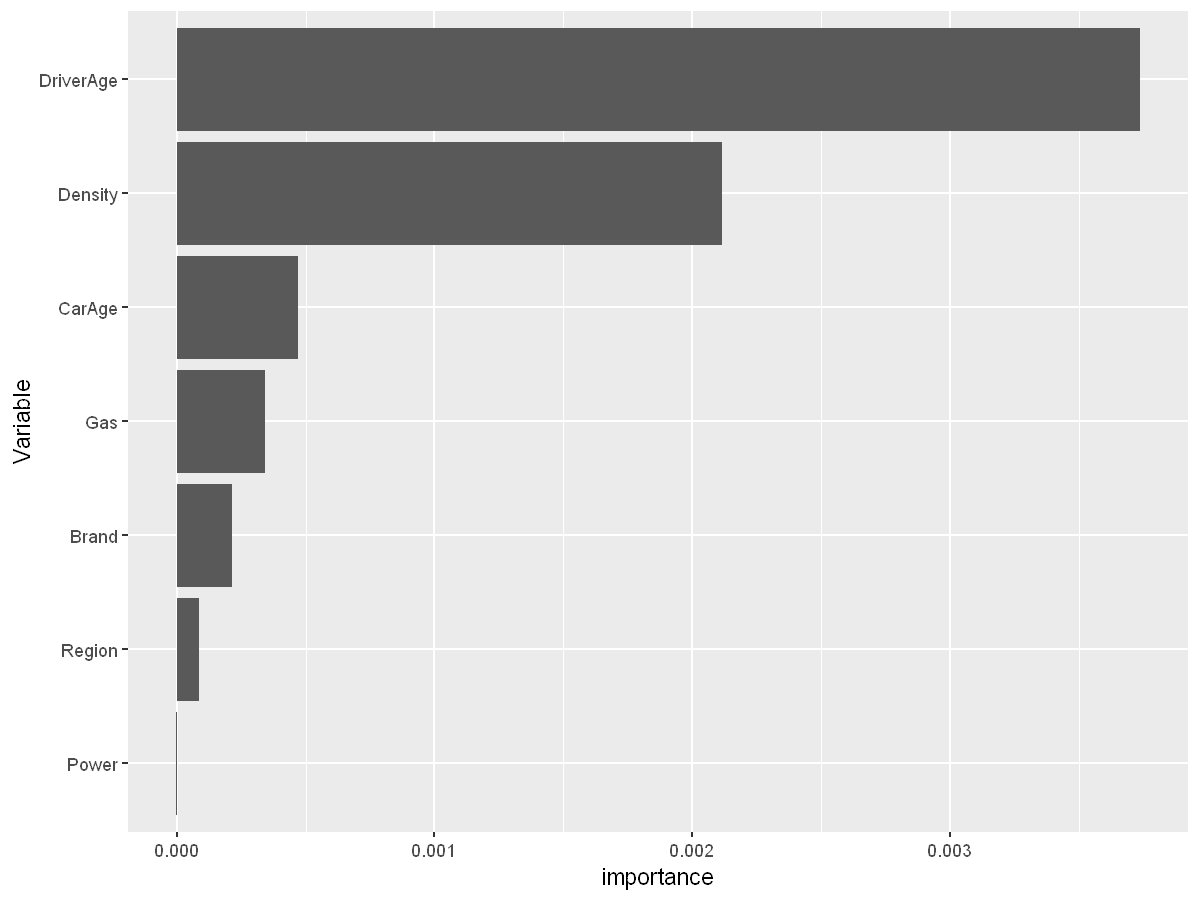

In [23]:
plotdata = as.data.frame(importance(m4_rf))
names(plotdata) = "importance"
plotdata$var = rownames(plotdata)

ggplot(plotdata,aes(x =reorder(var,importance), y=importance)) + geom_bar(stat='identity')+coord_flip()+
  scale_x_discrete(name="Variable")

Let us set the power variable as being **ordered** (Power will therefore be treated like a numerical variable) and reduce to 25 trees, only to allow a live demonstration.

In [24]:
training_set$Power_ordered = as.ordered(training_set$Power)
testing_set$Power_ordered = as.ordered(testing_set$Power)


set.seed(5)
m5_rf = rfPoisson(x = training_set[,c("Power_ordered","CarAge","DriverAge","Brand","Gas","Region","Density")],
                  offset = log(training_set$Exposure),
                  y = training_set$ClaimNb,
                  ntree = 25,
                  nodesize = 2500,
                  mtry=2,
                  importance=TRUE,
                  do.trace=TRUE)

     | OOB (1 tree) | OOB (forest) |
Tree |Loss Function |Loss Function |
   1 |     0.252944 |     0.252944 |
   2 |     0.250967 |     0.252326 |
   3 |     0.254465 |     0.252911 |
   4 |     0.254149 |     0.253392 |
   5 |     0.252165 |     0.253336 |
   6 |      0.25252 |     0.252949 |
   7 |     0.253915 |     0.252975 |
   8 |      0.25127 |     0.252687 |
   9 |     0.254466 |     0.252746 |
  10 |     0.256558 |     0.252748 |
  11 |     0.253905 |     0.252633 |
  12 |     0.256715 |     0.252561 |
  13 |     0.252875 |     0.252432 |
  14 |     0.250058 |     0.252395 |
  15 |     0.253584 |     0.252405 |
  16 |      0.25761 |     0.252356 |
  17 |     0.255958 |     0.252334 |
  18 |      0.25315 |     0.252336 |
  19 |     0.257933 |     0.252325 |
  20 |     0.253017 |     0.252307 |
  21 |     0.255431 |     0.252281 |
  22 |     0.255845 |     0.252255 |
  23 |     0.256721 |     0.252257 |
  24 |     0.257061 |     0.252246 |
  25 |     0.255371 |      0.25222 |


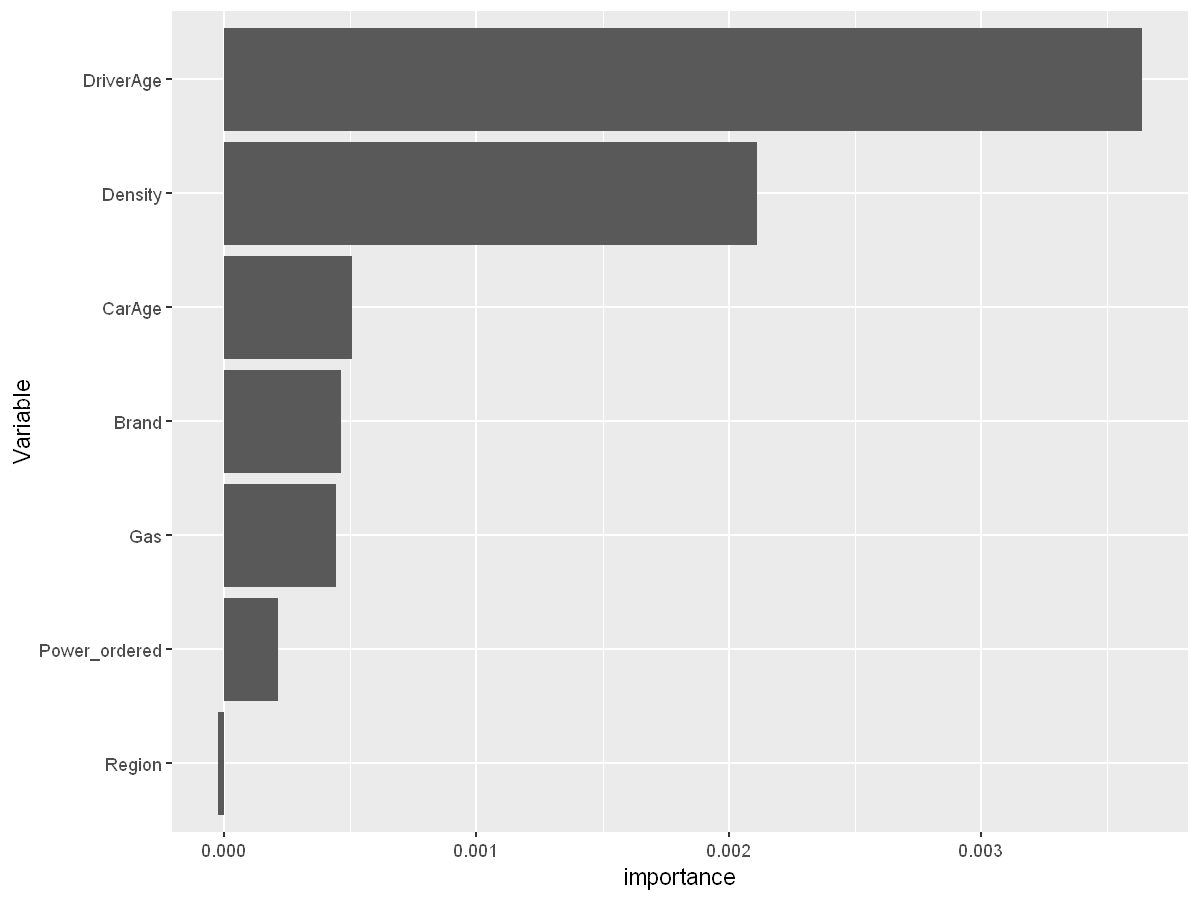

In [25]:
plotdata = as.data.frame(importance(m5_rf))
names(plotdata) = "importance"
plotdata$var = rownames(plotdata)

ggplot(plotdata,aes(x =reorder(var,importance), y=importance)) + geom_bar(stat='identity')+coord_flip()+
  scale_x_discrete(name="Variable")

The Power variable now appears to have some importance (to be checked, though, with more trees).

## Cross-Validation

We could rely on cross-validation to find the optimal hyper parameters, instead of Out-of-bag error. 

Ideally, we would construct a grid of possible hyperparameters. For instance, we could choose a set of possible values for *nodesize* and for *mtry*. Then, run the cross-validation on each of the possible cases.

However, due to time limitation of this live demo, we are only going to compare two different mtry parameter (due to the time limitation).

We will fasten the learning process by parallelizing the learning of the different forest on the different folds.

For mtry = 3 and nodesize = 10000,


In [26]:
set.seed(6)
folds = createFolds(training_set$ClaimNb, k = 5)
require(parallel)

Le chargement a nécessité le package : parallel



In [27]:
cl = makeCluster(5)
clusterExport(cl, "training_set")
set.seed(859)
res0 = parLapply(cl, folds, function(X) {
    require(rfCountData)
    m_cv = rfPoisson(x = training_set[-X, c("Power_ordered", "CarAge", "DriverAge",
        "Brand", "Gas", "Region", "Density")], offset = log(training_set[-X, ]$Exposure),
        y = training_set[-X, ]$ClaimNb, xtest = training_set[X, c("Power_ordered",
            "CarAge", "DriverAge", "Brand", "Gas", "Region", "Density")], offsettest = log(training_set[X,
            ]$Exposure), ytest = training_set[X, ]$ClaimNb, ntree = 100, nodesize = 10000,
        mtry = 3, importance = TRUE, do.trace = FALSE, keep.forest = FALSE)
    pred = m_cv$test$predicted
    2 * (sum(dpois(x = training_set[X, ]$ClaimNb, lambda = training_set[X, ]$ClaimNb,
        log = TRUE)) - sum(dpois(x = training_set[X, ]$ClaimNb, lambda = pred, log = TRUE)))/nrow(training_set[X,
        ])
})
stopCluster(cl)

For mtry = 5 and nodesize = 10000,



In [28]:
set.seed(6)
folds = createFolds(training_set$ClaimNb, k = 5)
require(parallel)
cl = makeCluster(5)
clusterExport(cl, "training_set")
set.seed(256)
res1 = parLapply(cl, folds, function(X) {
    require(rfCountData)
    m_cv = rfPoisson(x = training_set[-X, c("Power_ordered", "CarAge", "DriverAge",
        "Brand", "Gas", "Region", "Density")], offset = log(training_set[-X, ]$Exposure),
        y = training_set[-X, ]$ClaimNb, xtest = training_set[X, c("Power_ordered",
            "CarAge", "DriverAge", "Brand", "Gas", "Region", "Density")], offsettest = log(training_set[X,
            ]$Exposure), ytest = training_set[X, ]$ClaimNb, ntree = 100, nodesize = 10000,
        mtry = 5, importance = TRUE, do.trace = FALSE, keep.forest = FALSE)
    pred = m_cv$test$predicted
    2 * (sum(dpois(x = training_set[X, ]$ClaimNb, lambda = training_set[X, ]$ClaimNb,
        log = TRUE)) - sum(dpois(x = training_set[X, ]$ClaimNb, lambda = pred, log = TRUE)))/nrow(training_set[X,
        ])
})
stopCluster(cl)

We obtain the following results:

In [29]:
apply(cbind(unlist(res0), unlist(res1)), 2, mean)

[1] 0.2523652 0.2523348

We could also have tried different nodesize values. Due to time limitation, we will compare them using OOB error.

Let us now construct the whole forest on the whole training_set with the optimal mtry = 3.



In [30]:
set.seed(43)
m_final_1 = rfPoisson(x = training_set[, c("Power_ordered", "CarAge", "DriverAge",
    "Brand", "Gas", "Region", "Density")], offset = log(training_set$Exposure), y = training_set$ClaimNb,
    xtest = testing_set[, c("Power_ordered", "CarAge", "DriverAge", "Brand", "Gas",
        "Region", "Density")], offsettest = log(testing_set$Exposure), ytest = testing_set$ClaimNb,
    ntree = 100, nodesize = 10000, mtry = 3, importance = TRUE, do.trace = TRUE,
    keep.forest = TRUE)


     | OOB (1 tree) | OOB (forest) |   Test set   |
Tree |Loss Function |Loss Function |Loss Function |
   1 |     0.251576 |     0.251576 |     0.250529 |
   2 |     0.253316 |       0.2528 |     0.249736 |
   3 |     0.257191 |     0.253251 |     0.249471 |
   4 |     0.251813 |     0.253115 |     0.249375 |
   5 |      0.25794 |     0.253314 |      0.24922 |
   6 |     0.256251 |     0.253157 |     0.249222 |
   7 |     0.254984 |     0.253222 |     0.249155 |
   8 |     0.254975 |     0.253428 |     0.249183 |
   9 |     0.251809 |     0.253186 |     0.249101 |
  10 |     0.251829 |     0.252963 |     0.249084 |
  11 |     0.253822 |     0.252864 |     0.249108 |
  12 |      0.25576 |     0.252755 |     0.249086 |
  13 |     0.251545 |     0.252716 |     0.249085 |
  14 |     0.251005 |     0.252541 |     0.249066 |
  15 |     0.254899 |     0.252581 |     0.249084 |
  16 |     0.250148 |     0.252538 |      0.24908 |
  17 |     0.258254 |      0.25247 |      0.24908 |
  18 |      

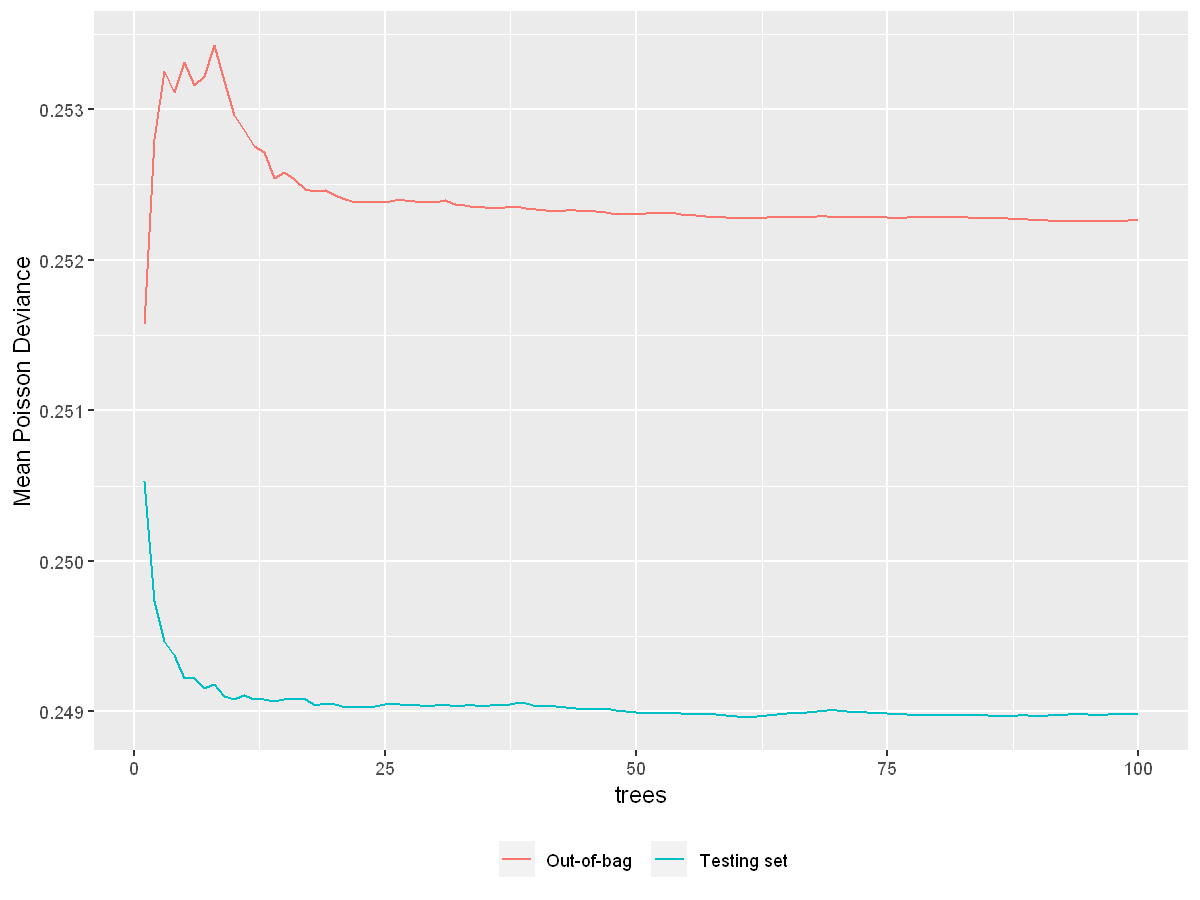

In [31]:
plot(m_final_1)

We can compare with a higher nodesize..

In [32]:
set.seed(43)
m_final_2 = rfPoisson(x = training_set[, c("Power_ordered", "CarAge", "DriverAge",
    "Brand", "Gas", "Region", "Density")], offset = log(training_set$Exposure), y = training_set$ClaimNb,
    xtest = testing_set[, c("Power_ordered", "CarAge", "DriverAge", "Brand", "Gas",
        "Region", "Density")], offsettest = log(testing_set$Exposure), ytest = testing_set$ClaimNb,
    ntree = 100, nodesize = 15000, mtry = 3, importance = TRUE, do.trace = TRUE,
    keep.forest = TRUE)


     | OOB (1 tree) | OOB (forest) |   Test set   |
Tree |Loss Function |Loss Function |Loss Function |
   1 |     0.251886 |     0.251886 |     0.251133 |
   2 |     0.253126 |     0.252785 |     0.249883 |
   3 |     0.257479 |     0.253368 |     0.249676 |
   4 |     0.251614 |     0.253143 |      0.24962 |
   5 |     0.260599 |     0.252911 |     0.249343 |
   6 |     0.254547 |     0.252996 |     0.249314 |
   7 |     0.253893 |     0.252944 |     0.249225 |
   8 |     0.251638 |     0.252817 |     0.249221 |
   9 |     0.251182 |     0.252852 |     0.249191 |
  10 |     0.251417 |     0.252864 |     0.249195 |
  11 |     0.253968 |     0.252823 |      0.24924 |
  12 |     0.254901 |     0.252856 |     0.249236 |
  13 |     0.252157 |     0.252733 |      0.24925 |
  14 |     0.252668 |     0.252745 |      0.24928 |
  15 |      0.25399 |     0.252669 |      0.24928 |
  16 |      0.25186 |     0.252648 |     0.249259 |
  17 |     0.258936 |     0.252685 |     0.249285 |
  18 |     0

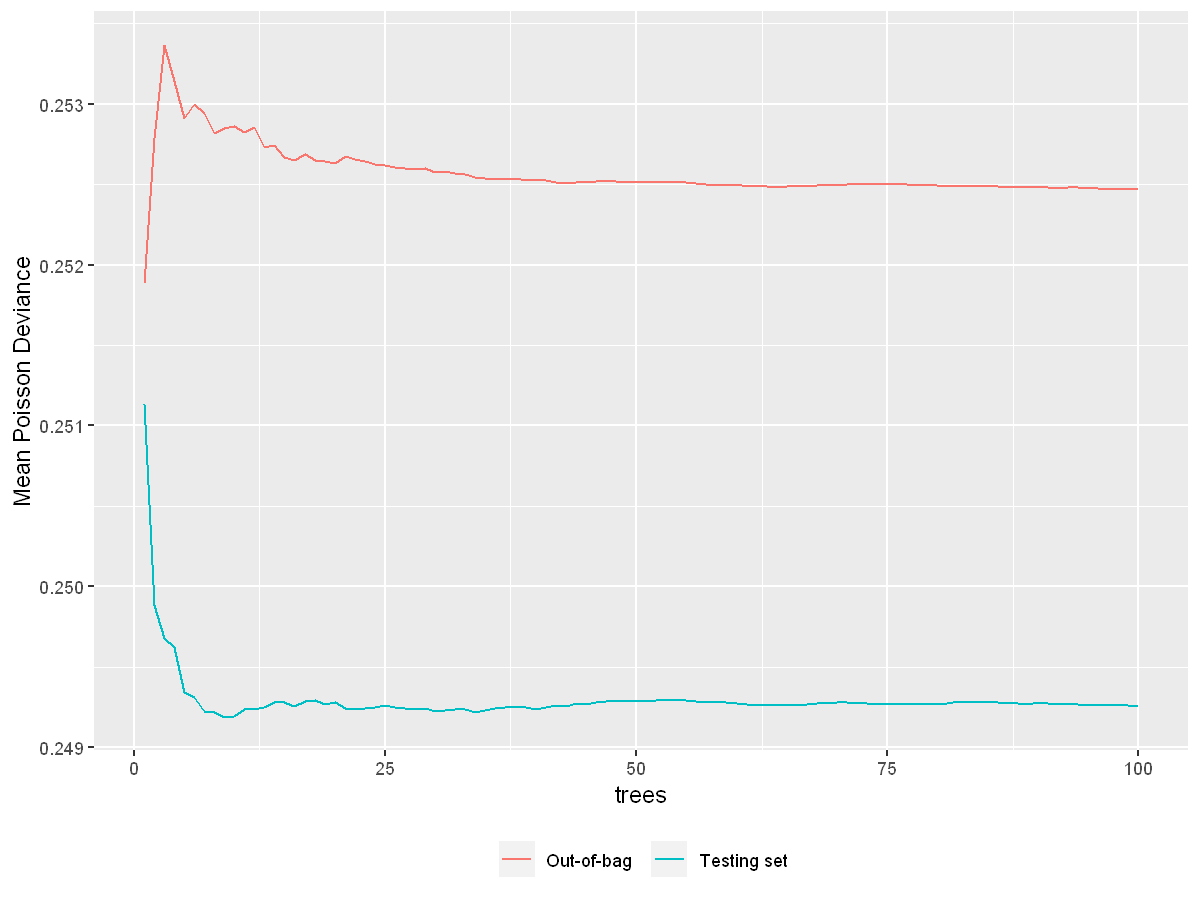

In [33]:
plot(m_final_2)

… and with a lower nodesize.

In [34]:
set.seed(43)
m_final_3 = rfPoisson(x = training_set[, c("Power_ordered", "CarAge", "DriverAge",
    "Brand", "Gas", "Region", "Density")], offset = log(training_set$Exposure), y = training_set$ClaimNb,
    xtest = testing_set[, c("Power_ordered", "CarAge", "DriverAge", "Brand", "Gas",
        "Region", "Density")], offsettest = log(testing_set$Exposure), ytest = testing_set$ClaimNb,
    ntree = 100, nodesize = 5000, mtry = 3, importance = TRUE, do.trace = TRUE, keep.forest = TRUE)

     | OOB (1 tree) | OOB (forest) |   Test set   |
Tree |Loss Function |Loss Function |Loss Function |
   1 |     0.252022 |     0.252022 |     0.250815 |
   2 |      0.25376 |     0.253335 |     0.250591 |
   3 |     0.257685 |     0.253645 |     0.250088 |
   4 |      0.25104 |     0.253176 |     0.249703 |
   5 |     0.257808 |     0.253199 |     0.249435 |
   6 |     0.256514 |     0.253074 |     0.249265 |
   7 |     0.254637 |     0.253118 |     0.249118 |
   8 |     0.255074 |     0.253313 |     0.249117 |
   9 |     0.252071 |     0.253217 |     0.249069 |
  10 |     0.253328 |      0.25305 |     0.249052 |
  11 |     0.252583 |     0.252918 |     0.249097 |
  12 |     0.253055 |     0.252864 |     0.249112 |
  13 |     0.252531 |     0.252708 |     0.249101 |
  14 |     0.251127 |      0.25254 |     0.249096 |
  15 |     0.254285 |     0.252538 |     0.249095 |
  16 |     0.251453 |     0.252497 |     0.249053 |
  17 |     0.257876 |     0.252434 |      0.24902 |
  18 |     0

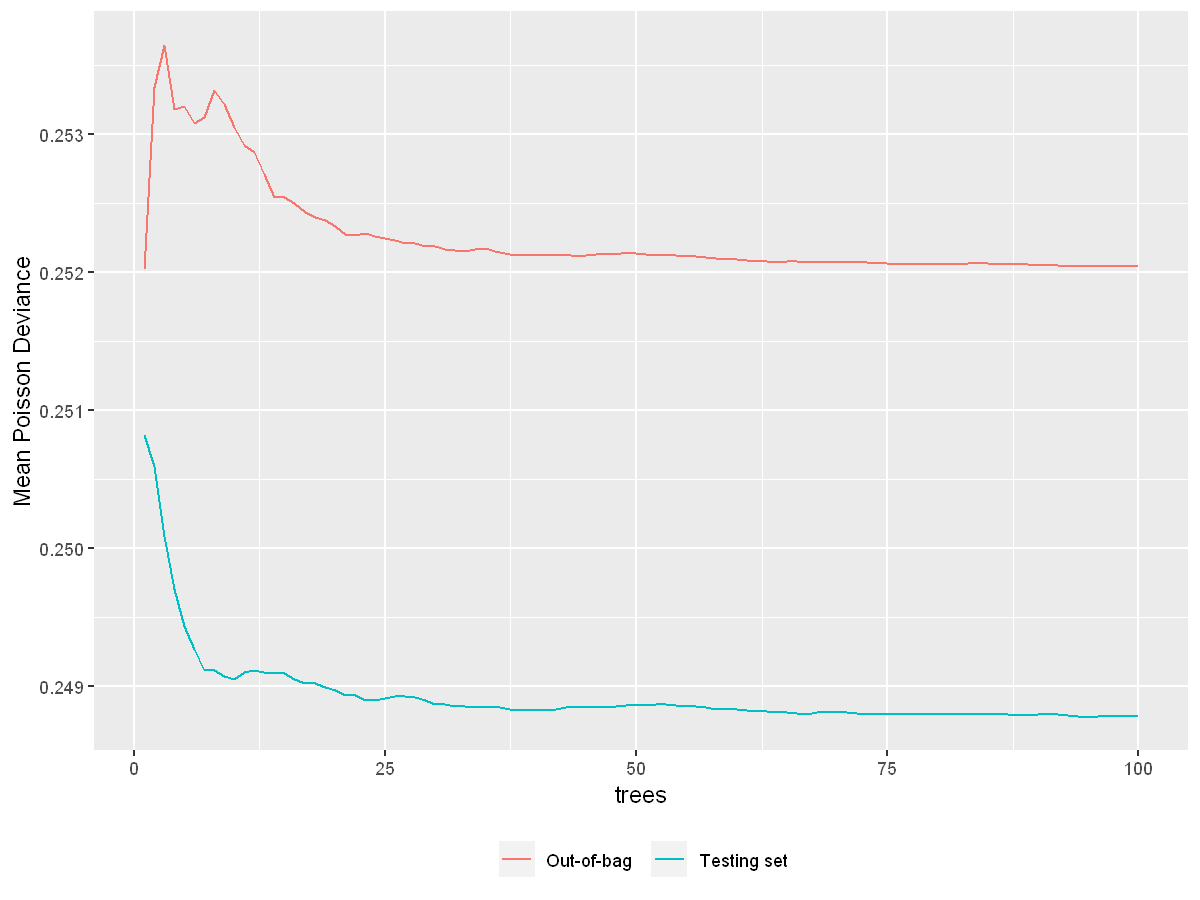

In [35]:
plot(m_final_3)

We conclude with the usual mean deviance on the testing_set

In [36]:
pred = predict(m_final_1, testing_set[,c("Power_ordered","CarAge","DriverAge","Brand","Gas","Region","Density")], offset = log(testing_set$Exposure))
2*(sum(dpois(x = testing_set$ClaimNb, lambda = testing_set$ClaimNb,log=TRUE))-
  sum(dpois(x = testing_set$ClaimNb, lambda = pred,
            log=TRUE)))

[1] 20459.87

In [37]:
pred = predict(m_final_2, testing_set[,c("Power_ordered","CarAge","DriverAge","Brand","Gas","Region","Density")], offset = log(testing_set$Exposure))
2*(sum(dpois(x = testing_set$ClaimNb, lambda = testing_set$ClaimNb,log=TRUE))-
  sum(dpois(x = testing_set$ClaimNb, lambda = pred,
            log=TRUE)))

[1] 20481.85

In [38]:
pred = predict(m_final_3, testing_set[,c("Power_ordered","CarAge","DriverAge","Brand","Gas","Region","Density")], offset = log(testing_set$Exposure))
2*(sum(dpois(x = testing_set$ClaimNb, lambda = testing_set$ClaimNb,log=TRUE))-
  sum(dpois(x = testing_set$ClaimNb, lambda = pred,
            log=TRUE)))

[1] 20442.94

In [39]:
end_time <- Sys.time()

In [40]:
end_time - start_time

Time difference of 38.25909 mins